## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/mathcothon-i-shalt-prepareth-data/MathCoThon_Ready_Meatballs.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

Ytrain = train_df['Price'].copy()
Ytrain_strat = pd.qcut(np.log1p(train_df['Price']), q=10, labels=range(0,10))
train_df.drop(['Price'], inplace=True, axis=1)

del processed_data
gc.collect()

0

In [3]:
with open("../input/mathcothon-denoised-meatballs/MathCoThon_Denoised_Meatballs.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
dae_train_df = processed_data['dae_train_df']
dae_test_df = processed_data['dae_test_df']

del processed_data
gc.collect()

20

In [4]:
cat_cols = ['Manufacturer','Model','Category','Leather interior','Cylinders',
            'Doors','Wheel','Color','Airbags','Turbo_Engine','Leap_Year',
            'Hybrid_Car','Numbers_in_Model','Drive wheels Front','Drive wheels Rear',
            'Manual_Gear','Automatic_Gear','Continuous_Gear','Fuel Tank Petrol',
            'Fuel Tank Diesel','Fuel Tank Gas','id0','id1','id2','id3','id4','id5','id6','id7']

vec_cols = [col for col in test_df.columns if (col.startswith('tfidf_') or col.startswith('countvec_'))]
num_cols = [col for col in test_df.columns if not(col in cat_cols or col in vec_cols)]

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)

In [5]:
Xtrain = pd.merge(train_df[cat_cols+num_cols], dae_train_df, on='ID', how='inner', sort=False)
Xtest = pd.merge(test_df[cat_cols+num_cols], dae_test_df, on='ID', how='inner', sort=False)
print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

cat_cols_indices = [Xtrain.columns.get_loc(col) for col in cat_cols]

del train_df
del test_df
gc.collect()

Xtrain: (15628, 349) 
Ytrain: (15628,) 
Xtest: (8245, 349)


20

## Build and validate the model

### Model-1

In [6]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp1 = 0
counter = 0
oof_score1 = 0
y_pred_meta_lgb1 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_lgb1 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = LGBMRegressor(
            boosting_type='gbdt', 
            num_leaves=75, 
            max_depth=7, 
            learning_rate=0.0107, 
            n_estimators=5000,
            objective='regression', 
            min_child_samples=5, 
            subsample=0.875, 
            subsample_freq=7, 
            colsample_bytree=0.6995, 
            reg_lambda=0.00489,
            random_state=(seed+idx)
        )
        
        model.fit(train_x, train_y, eval_metric='rmse',
                  eval_set=(val_x, val_y),
                  early_stopping_rounds=200, verbose=200,
                  categorical_feature=cat_cols_indices)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration_)
        y_pred_meta_lgb1[val] += np.array([y_pred]).T
        y_pred_final_lgb1 += model.predict(Xtest, num_iteration=model.best_iteration_)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score1 += score
        seed_score += score
        fet_imp1 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb1 = y_pred_meta_lgb1 / float(len(SEEDS))
y_pred_final_lgb1 = y_pred_final_lgb1 / float(counter)
fet_imp1 = fet_imp1 / float(counter)
oof_score1 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score1))

Training until validation scores don't improve for 200 rounds
[200]	valid_0's rmse: 0.997173	valid_0's l2: 0.994353
[400]	valid_0's rmse: 0.951008	valid_0's l2: 0.904417
[600]	valid_0's rmse: 0.937763	valid_0's l2: 0.8794
[800]	valid_0's rmse: 0.931367	valid_0's l2: 0.867445
[1000]	valid_0's rmse: 0.929964	valid_0's l2: 0.864834
[1200]	valid_0's rmse: 0.928492	valid_0's l2: 0.862097
Early stopping, best iteration is:
[1117]	valid_0's rmse: 0.927411	valid_0's l2: 0.860092
Seed-2020 | Fold-0 | OOF Score: 0.92530596718046
Training until validation scores don't improve for 200 rounds
[200]	valid_0's rmse: 0.953526	valid_0's l2: 0.909212
[400]	valid_0's rmse: 0.92823	valid_0's l2: 0.86161
[600]	valid_0's rmse: 0.923746	valid_0's l2: 0.853306
[800]	valid_0's rmse: 0.92343	valid_0's l2: 0.852722
[1000]	valid_0's rmse: 0.923096	valid_0's l2: 0.852106
[1200]	valid_0's rmse: 0.922265	valid_0's l2: 0.850573
[1400]	valid_0's rmse: 0.920682	valid_0's l2: 0.847656
[1600]	valid_0's rmse: 0.920784	val

### Model-2

In [7]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp2 = 0
counter = 0
oof_score2 = 0
y_pred_meta_lgb2 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_lgb2 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = LGBMRegressor(
            boosting_type='gbdt', 
            num_leaves=246, 
            max_depth=8, 
            learning_rate=0.012, 
            n_estimators=5000, 
            objective='regression', 
            min_child_samples=4, 
            subsample=0.82, 
            subsample_freq=3, 
            colsample_bytree=0.656, 
            reg_lambda=0.0336, 
            random_state=(seed+idx)
        )
        
        model.fit(train_x, train_y, eval_metric='rmse',
                  eval_set=(val_x, val_y),
                  early_stopping_rounds=200, verbose=1000,
                  categorical_feature=cat_cols_indices)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration_)
        y_pred_meta_lgb2[val] += np.array([y_pred]).T
        y_pred_final_lgb2 += model.predict(Xtest, num_iteration=model.best_iteration_)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score2 += score
        seed_score += score
        fet_imp2 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb2 = y_pred_meta_lgb2 / float(len(SEEDS))
y_pred_final_lgb2 = y_pred_final_lgb2 / float(counter)
fet_imp2 = fet_imp2 / float(counter)
oof_score2 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score2))

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.931269	valid_0's l2: 0.867262
Early stopping, best iteration is:
[1194]	valid_0's rmse: 0.930807	valid_0's l2: 0.866402
Seed-2020 | Fold-0 | OOF Score: 0.9287361429741536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[713]	valid_0's rmse: 0.918312	valid_0's l2: 0.843296
Seed-2020 | Fold-1 | OOF Score: 0.916647752437703
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[401]	valid_0's rmse: 0.931561	valid_0's l2: 0.867805
Seed-2020 | Fold-2 | OOF Score: 0.9300126658674415
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.922371	valid_0's l2: 0.850769
Early stopping, best iteration is:
[964]	valid_0's rmse: 0.92205	valid_0's l2: 0.850176
Seed-2020 | Fold-3 | OOF Score: 0.9201949790583248
Training until validation scores don't improve for 200 rounds
Early stopping, best 

In [8]:
np.savez_compressed('./LGB_Meta_Features.npz',
                    y_pred_meta_lgb1=y_pred_meta_lgb1,
                    y_pred_meta_lgb2=y_pred_meta_lgb2,
                    oof_score1=oof_score1,
                    oof_score2=oof_score2,
                    y_pred_final_lgb1=y_pred_final_lgb1,
                    y_pred_final_lgb2=y_pred_final_lgb2)

## Create submission file

In [9]:
y_pred_final_lgb = (y_pred_final_lgb1 + y_pred_final_lgb2) / 2.0

In [10]:
train_df = pd.read_csv("../input/mathcothon/train.csv")
test_df = pd.read_csv("../input/mathcothon/test.csv")

check_cols = [col for col in train_df.columns if col != 'ID']
train_df = train_df[~train_df.duplicated(subset=check_cols, keep='first')].copy()
print(f"Num records after Step-1: {train_df.shape[0]}")

check_cols = [col for col in train_df.columns if col not in ['ID','Price']]
train_df = train_df.groupby(check_cols).agg({'Price':'mean'}).reset_index().copy()
print(f"Num records after Step-2: {train_df.shape[0]}")

Num records after Step-1: 15725
Num records after Step-2: 15463


In [11]:
train_cols = [col for col in train_df.columns if col != 'ID']
test_cols = [col for col in test_df.columns if col not in ['ID','Price']]

df = pd.merge(
    test_df[test_cols], 
    train_df[train_cols], 
    how='left', 
    on=test_cols,
    sort=False
)

df = df.rename(columns={'Price': 'Train_Price'})
df['Predicted_Price'] = np.exp(y_pred_final_lgb)
df['Price'] = df.apply(lambda row: row['Predicted_Price'] if pd.isnull(row['Train_Price']) else row['Train_Price'], axis=1)
print(f"df: {df.shape}")
df.head()

df: (8245, 19)


,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Train_Price,Predicted_Price,Price
0,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN,8956.853252,8956.853252
1,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN,9829.038757,9829.038757
2,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN,9127.243948,9127.243948
3,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN,7093.790570,7093.790570
4,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN,4028.689170,4028.689170


In [12]:
df.loc[df['Manufacturer']=='TESLA','Price'] = 53941
df.loc[df['Manufacturer']=='SATURN','Price'] = 13799
df.loc[df['Manufacturer']=='ASTON MARTIN','Price'] = 54000
df.loc[(df['Manufacturer']=='GREATWALL')&(df['Model']=='C30'),'Price'] = 10036

df.loc[df['Prod. year']==1943,'Price'] = 119172
df.loc[df['Prod. year']==1968,'Price'] = 2200
df.loc[df['Prod. year']==1981,'Price'] = 2800

df.loc[df['Fuel type']=='Hydrogen','Price'] = 20385

df.loc[df['Engine volume']=='0.3 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='0.5', 'Price'] = 1300
df.loc[df['Engine volume']=='0.8 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='3.1', 'Price'] = 8781
df.loc[df['Engine volume']=='5.2', 'Price'] = 13000
df.loc[df['Engine volume']=='6.7', 'Price'] = 1019

In [13]:
submit_df = pd.DataFrame()
submit_df['Price'] = df['Price']
submit_df.to_csv("./LGB_Submission.csv", index=False)
submit_df.head()

,Price
0,8956.853252
1,9829.038757
2,9127.243948
3,7093.790570
4,4028.689170


## Features Importance

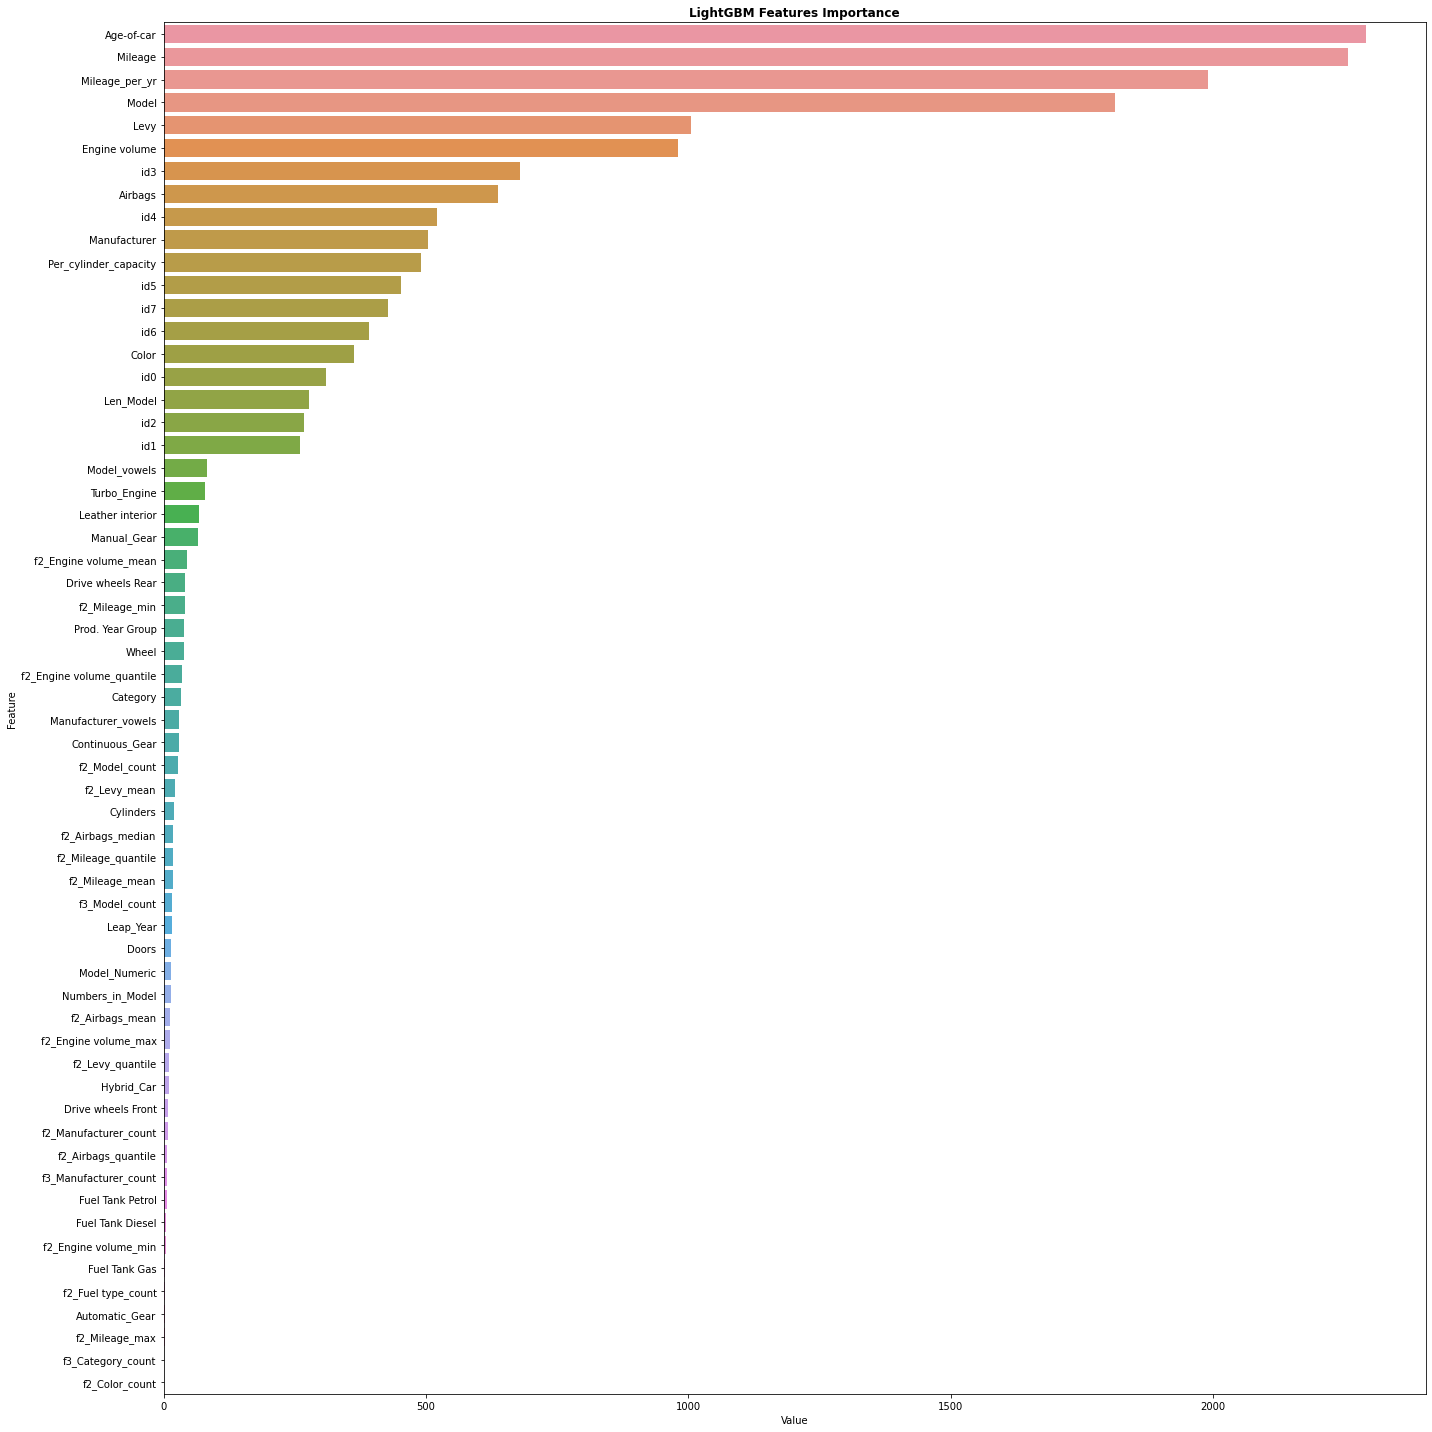

In [14]:
fet_imp = (fet_imp1 + fet_imp2)/2.0
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60],Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()